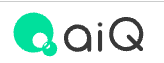

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS Csmr Goods Evaluation Notebook
- aiQ POS Csmr Goods consolidates sales data for products sold in retail stores such as supermarkets, drugstores, and convenience stores, organized by TICKER.
- Prescription medications, fresh foods without barcodes, and other similar items are not included in the product coverage.

In [1]:
# Commands to automatically update custom modules.
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

verbose = False
for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [4]:
sdh.extract.clear()

# Register various demo data into the data handler (`sdh`).
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh, base_data_id=data_id_alt)
data_id_funda = sc_common.register_fundamental(sdh)

# Check the registered `data_id`.
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,external,sample,Unknown,pos_csmr_goods,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2008-03-16 00:00:00,2024-08-25 00:00:00
2,RawData,External,Unknown,Unknown,market_returns,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-08-30 00:00:00
3,RawData,External,Unknown,Unknown,funda,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-04-20 00:00:00,2024-05-31 00:00:00


In [5]:
# Randomly select a TICKER to use as a sample for plotting.
sample_target = "2281"

In [6]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9997   2024-07-28   0.002344  0.000137    0.797644           0.551641
       2024-08-04   0.002702  0.000153    1.014569           0.715358
       2024-08-11   0.002361  0.000127    0.749142           0.501099
       2024-08-18   0.004074  0.000207    0.902998           0.614507
       2024-08-25   0.002135  0.000124    1.116483           0.787637

returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9997   2024-08-26 -0.016416   -0.001356   -0.016416    0.000000
       2024-08-27  0.000000   -0.010914   -0.005502    0.005502
       2024-08-28  0.016416   -0.005502    0.016416    0.000000
       2024-08-29 -0.002717    0.015058   -0.001360   -0.001358
       2024-08-30  0.009479    0.002714    0.005405    0.004073

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [7]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler, please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [8]:
USE_MY_MKT = False 

## Step3: Correlation Analysis

### Create `AltDataEvaluator`
Given the nature of aiQ POS Csmr Goods data, it is expected that there is a correlation with financial data (quarterly sales).

We will test this hypothesis here to determine its validity.

#### The `AltDataEvaluator` will be used for evaluating alternative data.

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

# Configure the settings so that the calculation process logs are not output. (Setting it to True will enable logging)
sdh.transform.verbose = verbose

#### Retrieve the features from aiQ POS Csmr Goods and store them for later use.

In [10]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object', name='VARIABLE')

#### Compare the quarterly sales data loaded in Step 2 with the `pos_sales` from POS Csmr Goods
- To make the comparison possible, resample the `pos_sales` data to match the frequency of the quarterly sales data.

In [11]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.raw(data_id=data_id_funda).variable_ids
alt_Q_ids = sdh.transform.resample_by(label=funda_Q_ids[0], func='mean', data_id=data_id_alt).variable_ids

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your own financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [12]:
if USE_MY_FUNDA:

    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_ids[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X= alt_Q_ids, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=30, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_Q_ids[0], func='mean').variable_ids

    # View Sales vs Pos Sales
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=[alt_Q_shift_1_ids[0], alt_Q_shift_2_ids[0], 
           alt_Q_shift_3_ids[0], alt_Q_shift_4_ids[0]],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_id = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]

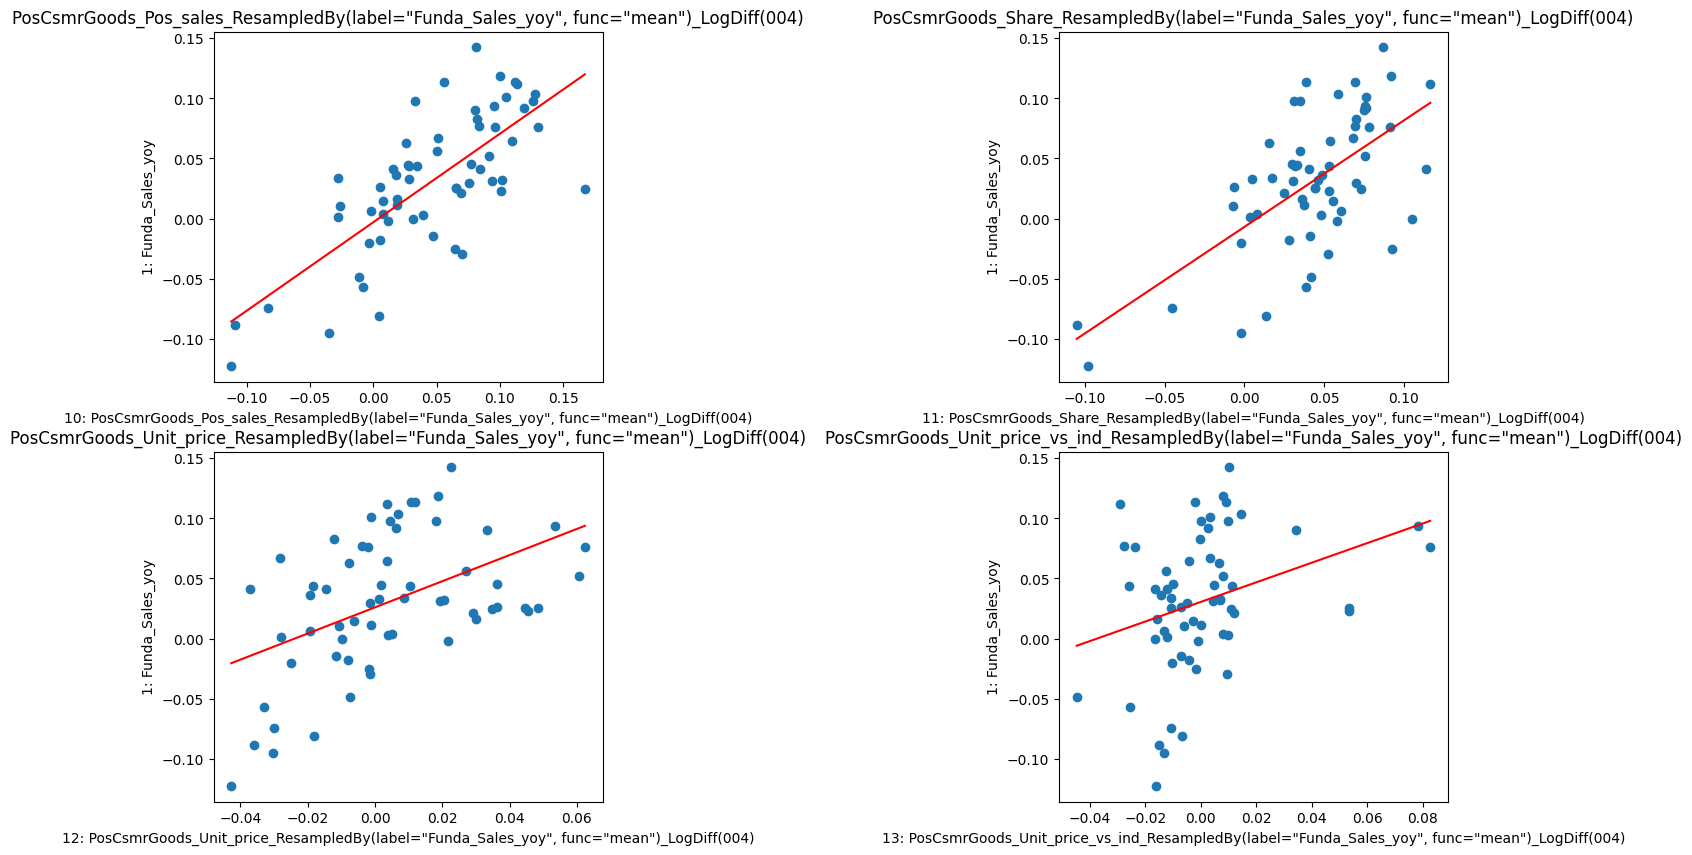

In [13]:
if not USE_MY_FUNDA:
    
    # Convert `pos_sales` to YoY as well for comparison with the financial data.
    alt_Q_yoy_ids = sdh.transform.log_diff(periods=4, fields=alt_Q_ids).variable_ids
    
    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=alt_Q_yoy_ids,
        col_num=2
    )

    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_Q_ids[0], func='mean').variable_ids

    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_id = sdh.transform.diff(fields=funda_Q_ids, periods=1).variable_ids[-1]

#### Verify using variables that have been lagged with the first difference of the alternative data features.

In [14]:
alt_Q_shift_0_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_ids, periods=4).variable_ids
alt_Q_shift_1_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_1_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_2_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_2_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_3_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_3_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_4_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_4_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

,data_id,variable_id,step_001,step_002,step_003,step_004
process_id,,,,,,
13,3,[46],raw(),diff(periods=1),,
4,1,"[10, 11, 12, 13]",-,"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),-
15,1,"[51, 52, 53, 54]",shift(periods=1),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1)
17,1,"[59, 60, 61, 62]",shift(periods=2),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1)
19,1,"[67, 68, 69, 70]",shift(periods=3),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1)
21,1,"[75, 76, 77, 78]",shift(periods=4),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1)


#### Execute the correlation calculations one by one.

In [15]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0'] = ade.compu_rho(alt_Q_shift_0_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=1'] = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=2'] = ade.compu_rho(alt_Q_shift_2_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=3'] = ade.compu_rho(alt_Q_shift_3_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=4'] = ade.compu_rho(alt_Q_shift_4_logdiff_ids, sales_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=0,n_shift=1,n_shift=2,n_shift=3,n_shift=4
pos_sales,3.244714,11.316954,8.413976,5.932159,4.769389
unit_price_vs_ind,0.285898,1.023652,0.415687,-0.299486,-0.735402
share,-0.133730,4.395785,3.592493,2.625311,3.562496
unit_price,-2.483611,-1.004597,-1.668304,-2.579399,-2.617638


In [16]:
# Retrieve the results from the contents of the pooled DataFrame.
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=0,n_shift=1,n_shift=2,n_shift=3,n_shift=4
pos_sales,0.028032,0.098293,0.073251,0.052040,0.041871
unit_price_vs_ind,0.002471,0.008934,0.003629,-0.002631,-0.006462
share,-0.001156,0.038337,0.031345,0.023056,0.031288
unit_price,-0.021460,-0.008767,-0.014562,-0.022653,-0.022995


#### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [17]:
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
TICKER,,,,
2226,9.500869,6.554818,-0.042537,0.298083
2220,7.280671,5.711003,-0.434502,-1.965568
2804,6.135112,0.524333,1.046190,-1.138697
2208,5.889190,1.437646,2.672743,1.524452
2908,5.538624,0.398367,0.781101,0.905671


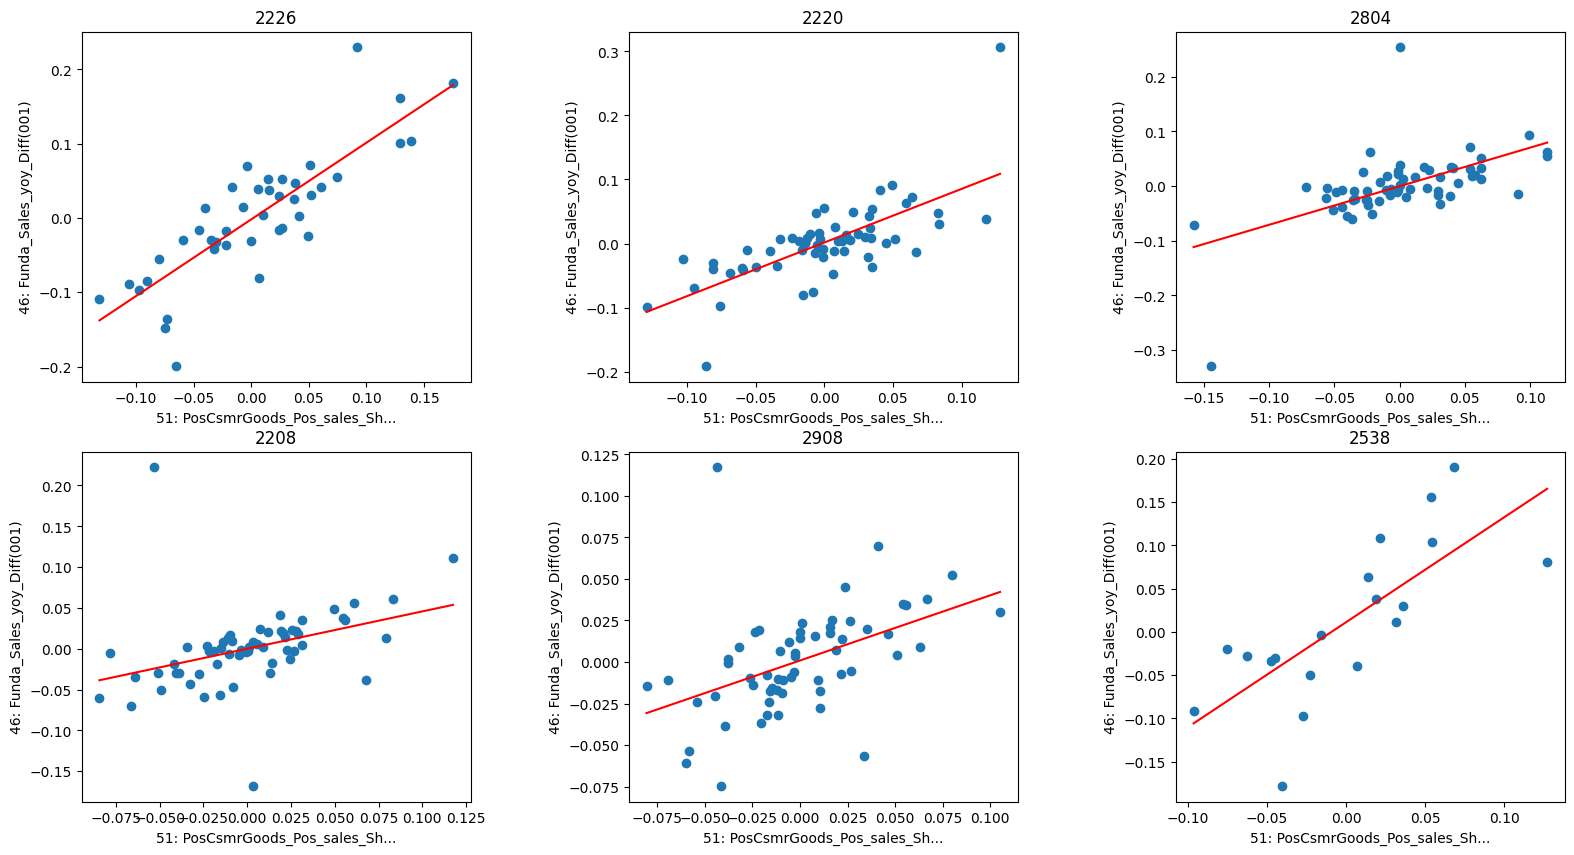

In [18]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=alt_Q_shift_1_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### Step 3.2: Correlation with Stock Price Changes
- Having confirmed a strong relationship between financial data and POS Csmr Goods, the next step is to examine the correlation with stock price changes.
- To align the stock price data with the POS data, resample it to weekly data for comparison.

In [19]:
if USE_MY_MKT:
     mkt_W_close_id = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variable_ids[-1]
else:
     mkt_W_close_id = sdh.transform.fillna(0, data_id=data_id_mkt, fields='returns').cumsum().resample(rule='W', func='last').variable_ids[-1]
    
alt_W_ids = sdh.transform.resample(data_id=data_id_alt, rule='W', func='mean').variable_ids

#### Plotting with Stock Prices

Similar to the comparison with financial data, plot the data to understand its shape and structure.

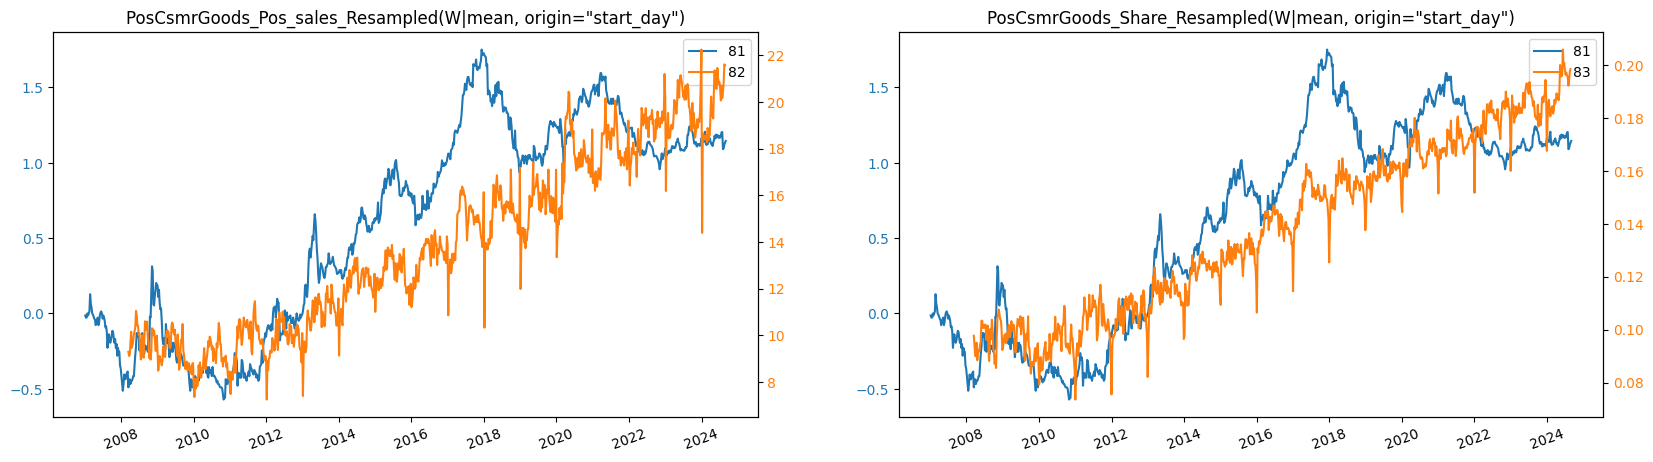

In [20]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=alt_W_ids[:2],
    col_num=2
)

##### Explore the Optimal Shift Interval in the Same Way as the Comparison with Financial Data

In [21]:
alt_W_shift_0_ids = sdh.transform.sma(fields=alt_W_ids, periods=12).variable_ids
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='W', func='mean').sma(periods=12).variable_ids

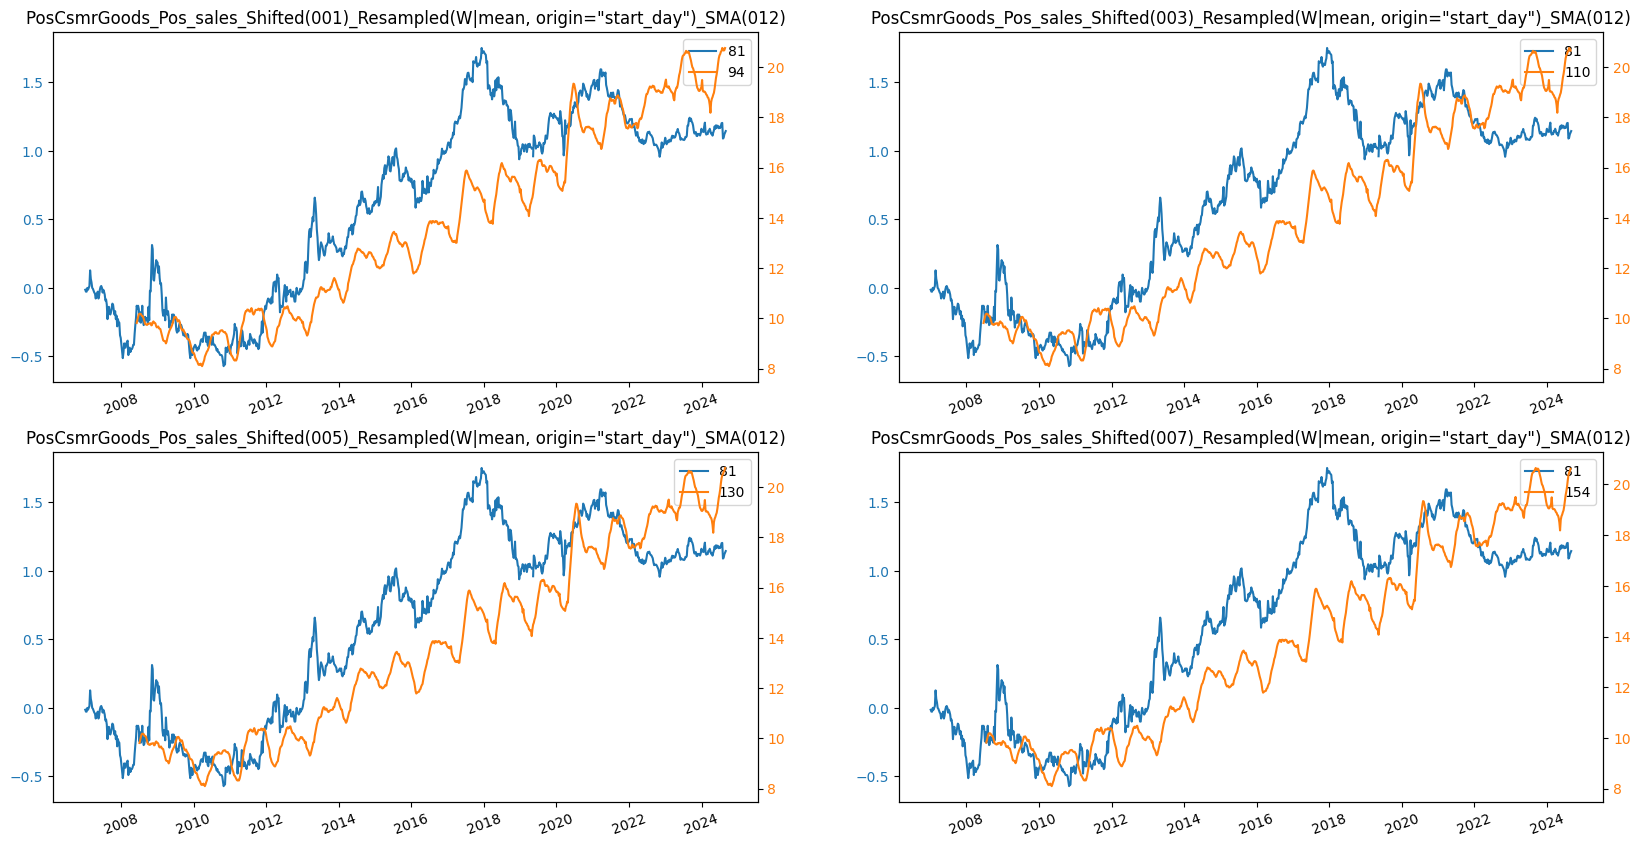

In [22]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=[alt_W_shift_1_ids[0], alt_W_shift_3_ids[0], 
       alt_W_shift_5_ids[0], alt_W_shift_7_ids[0]],
    col_num=2
)

> Make `return`

In [23]:
if USE_MY_MKT:
    close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').log_diff(periods=1, names='ret').variable_ids[-1]
else:
    close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').diff(periods=1, names='ret').variable_ids[-1]

> Calculate the year-over-year (YoY) change for the same week before performing the correlation analysis.

In [24]:
alt_W_shift_0_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_0_ids, periods=52).variable_ids
alt_W_shift_1_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_1_ids, periods=52).variable_ids
alt_W_shift_2_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_2_ids, periods=52).variable_ids
alt_W_shift_3_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_3_ids, periods=52).variable_ids
alt_W_shift_4_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_4_ids, periods=52).variable_ids
alt_W_shift_5_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_5_ids, periods=52).variable_ids
alt_W_shift_6_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_6_ids, periods=52).variable_ids
alt_W_shift_7_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_7_ids, periods=52).variable_ids
alt_W_shift_8_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_8_ids, periods=52).variable_ids

# Check the Method Chain
sdh.transform.show_method_chain()

,data_id,variable_id,step_001,step_002,step_003,step_004,step_005
process_id,,,,,,,
13,3,[46],raw(),diff(periods=1),,,
4,1,"[10, 11, 12, 13]",-,"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),-,
15,1,"[51, 52, 53, 54]",shift(periods=1),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1),
17,1,"[59, 60, 61, 62]",shift(periods=2),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1),
19,1,"[67, 68, 69, 70]",shift(periods=3),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1),
21,1,"[75, 76, 77, 78]",shift(periods=4),"resample_by(label=""Funda_Sales_yoy"", func=""mean"")",log_diff(periods=4),diff(periods=1),
48,2,[171],fillna(value=0.0),cumsum(),"resample(rule=""W"", func=""last"", origin=""start_day"")","dropna(how=""all"")",diff(periods=1)
49,1,"[172, 173, 174, 175]",-,"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52),
50,1,"[176, 177, 178, 179]",shift(periods=1),"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52),


> Calculate the correlation coefficient and its T-value.

In [25]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0, sma=12'] = ade.compu_rho(alt_W_shift_0_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=1, sma=12'] = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=2, sma=12'] = ade.compu_rho(alt_W_shift_2_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=3, sma=12'] = ade.compu_rho(alt_W_shift_3_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=4, sma=12'] = ade.compu_rho(alt_W_shift_4_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=5, sma=12'] = ade.compu_rho(alt_W_shift_5_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=6, sma=12'] = ade.compu_rho(alt_W_shift_6_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=7, sma=12'] = ade.compu_rho(alt_W_shift_7_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=8, sma=12'] = ade.compu_rho(alt_W_shift_8_sma12_logdiff_ids, close_ret, rename_features=features)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,"n_shift=0, sma=12","n_shift=1, sma=12","n_shift=2, sma=12","n_shift=3, sma=12","n_shift=4, sma=12","n_shift=5, sma=12","n_shift=6, sma=12","n_shift=7, sma=12","n_shift=8, sma=12"
pos_sales,6.816172,6.880719,6.431995,6.405186,6.256882,5.709882,5.175617,5.067990,4.597525
share,3.292553,3.272012,2.908878,2.685543,2.703872,2.452845,2.200480,2.220979,2.022449
unit_price,0.617549,0.697091,0.811874,0.956283,1.077171,1.236140,0.964301,0.620189,0.413122
unit_price_vs_ind,0.264319,0.209272,0.455789,0.594643,0.452991,0.698160,0.338926,-0.003765,-0.115838


> Select the top N Tickers with the highest correlation and visually inspect their relationships using scatter plots.

In [26]:
rho_time = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
TICKER,,,,
5194,3.846740,4.034565,2.469087,2.058265
2281,3.329594,3.339506,2.146189,0.756446
2212,2.858078,1.489544,0.839138,-0.052785
2884,2.778783,0.177698,0.437596,1.772377
2816,2.644525,0.776717,0.062236,1.308531


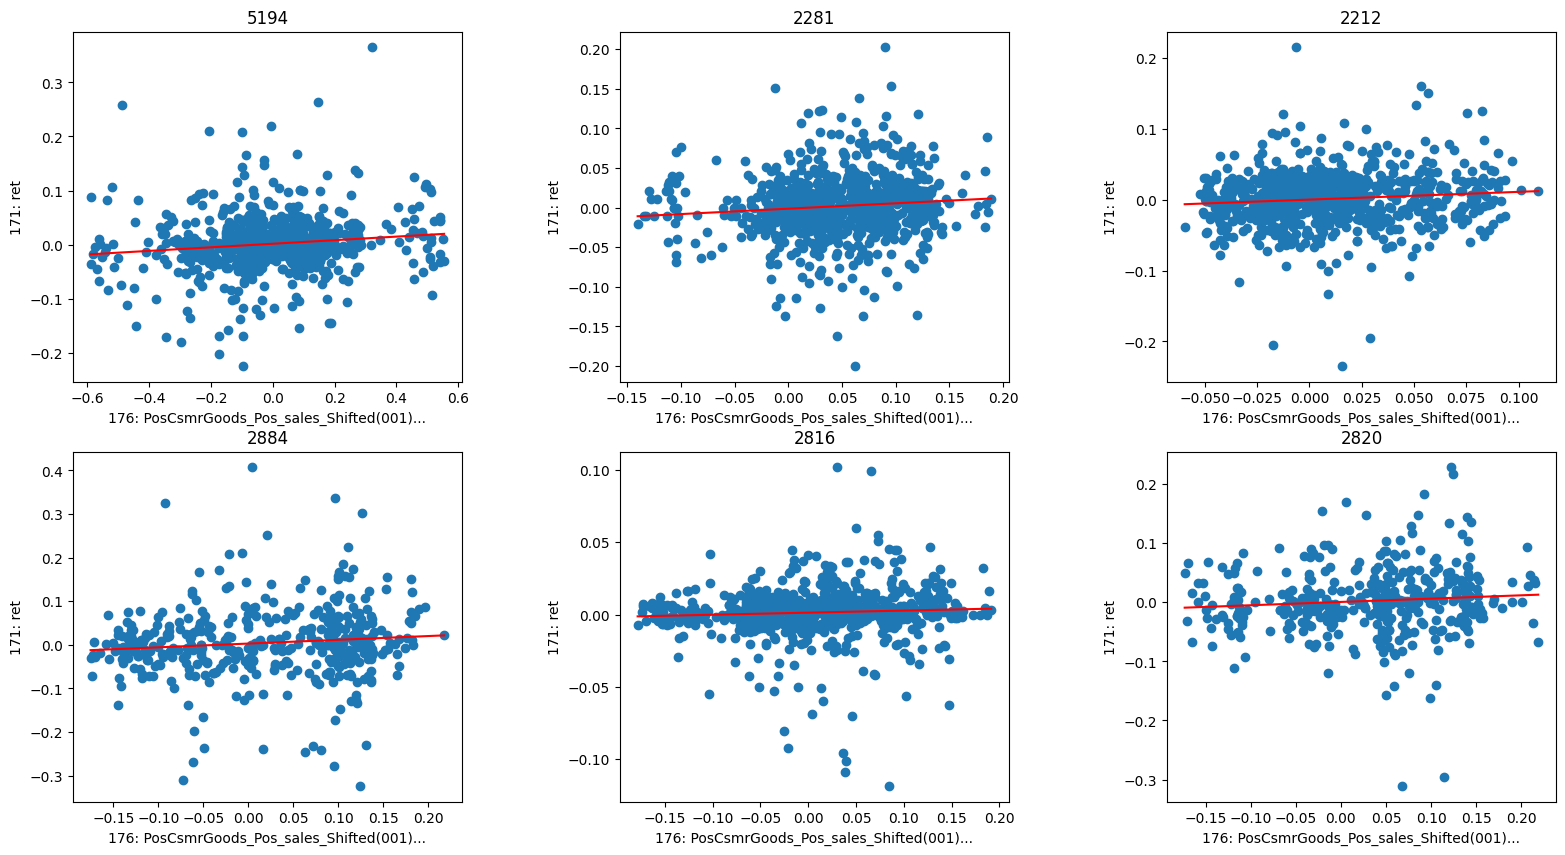

In [27]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_ret,
    x=alt_W_shift_1_sma12_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 12-week moving average of `pos_sales` is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [28]:
# Create a tercile (three-quantile) portfolio.
nq = 3

# Assume one-way transaction costs.
exe_cost = 0.0005

# Retrieve the `variable_id` that was calculated in Step 3.
pos_sales = alt_W_shift_1_sma12_logdiff_ids[0]
ret = close_ret

In [29]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.656015,0.043081,0.139149,0.309605,0.585642,2.751476,-0.465121,0.092624
#2,0.655394,0.043040,0.134280,0.320528,0.570529,5.186912,-0.412048,0.104455
#3,1.318190,0.086567,0.137955,0.627503,0.590680,2.740603,-0.418595,0.206803
#3-#1,0.662174,0.043486,0.046963,0.925961,0.570529,5.492079,-0.078408,0.554609
#3-#1(cost),0.620412,0.040743,0.046964,0.867548,0.564232,5.492079,-0.079799,0.510573
